# Supervised Learning
## Project: Finding Donors for *CharityML*

### Contents
1. Introduction
2. Data Import
3. Data Exploration
4. Preprocessing
5. Model Performance

___

## 1. Introduction

The following project implements several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census.

After some preliminary data exploration I proceed to construct a model with the goal of accurately predicting whether an individual makes more than \$50,000 or not.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). 

The dataset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_ and can be found  [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data used in this notebook consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

--- 
## 2. Data Import 
Load necessary Python libraries and load the census data. The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display 

# Import supplementary visualization code visuals.py
import visuals as vs

# plotting in notebook
%matplotlib inline

# Load census csv

data = pd.read_csv("census.csv")

---
## 3. Data Exploration
Basic exploration and descriptive statistics.

In [2]:
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [3]:
# Calculate descriptive statistics
n_records = data.shape[0]
n_greater_50k = (data["income"] ==">50K").sum() 
n_at_most_50k = (data["income"] =="<=50K").sum()
greater_percent = (n_greater_50k / n_records)*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.4}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


Note that that many variables are nominally scaled. In order to apply our algorithms some preprocessing is required. Therefore, dummy variables will be added for each non-continous variable aka one-hot-encoding.

Example: 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 

As there is no natural order between all features, they will be treated equally. The way to implement this is to include a binary variable (or dummy) for each category indicating whether the individual "possesses" this characteristic or not.

For more information on the features I refer to the metadata accessible under the aforementioned link.

----
## 4. Preprocessing
In this section some preprocessing must be applied. Fortunately, there are no invalid or missing entries we must deal with as this dataset has already been cleaned. For more information on how to deal with missings and invalid entries I refer to my project of **Customer Segmentation (Unsupervised Learning)**. 

However, there are some qualities about certain features that must be adjusted. This preprocessing helps with the outcome and predictive power of most supervised learning algorithms. The following preprocessing consists of: 

- Splitting data into features and label (x,y)
- Transforming skewed continous features (log-transform)
- Normalizing numerical features to (0,1)
- Include dummy variables for categorical features (aka one-hot encoding)
- Shuffle and split the data 

### Transforming Skewed Continuous Features
Two features are heavily skewed towards one value, namely: 

'`capital-gain'` and `'capital-loss'`

Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. 

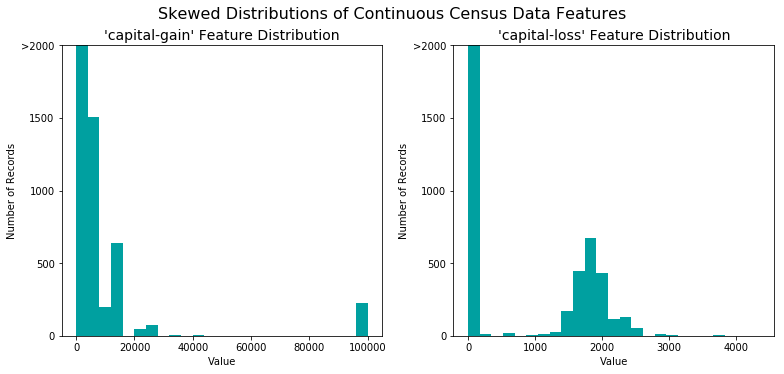

In [4]:
# Visualize skewed continuous features of original data
vs.distribution(data)

As the values vary by a lot, a data transformation seems to be appropriate here. I will use a simple logarithmic transformation to reduce the range of values. Other data transformations (e.g. Box-Cox transformation) may also be applied here.

The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Before the transformation I will split the data into features and target label.

In [5]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

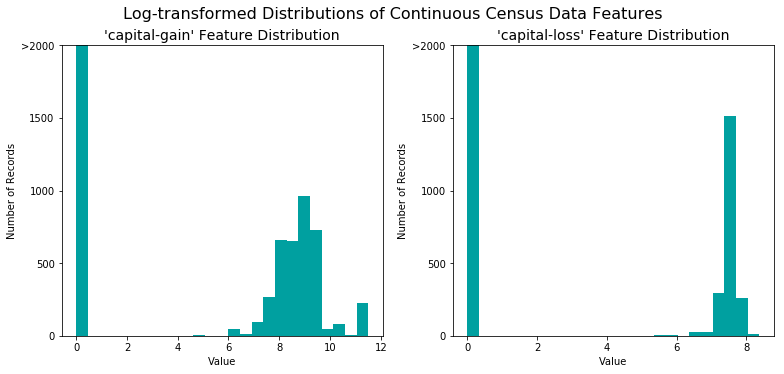

In [6]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
Moreover, I will apply a scaling to the numerical data features to ensure that each feature is treated equally when applying supervised learning algorithms. The shape of a feature's distribution remains the same.

Once scaling is applied, observing the data in its raw form will no longer have the same original meaning.

I will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this, which scales the data to a range of (0,1) by default. 

In [7]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with applied scaling
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing
As mentione before, there are several categorical variables for each record. Most supervised algorithms expect input to be numeric and, thus, categorical features ought to be converted. One way is to use dummy variables (one-hot encoding) for each possible category. 

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as a binary variable of `0` and `1`, respectively. 

In [8]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.map({"<=50K": 0, ">50K":1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded[:20])

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm']


### Shuffle and Split Data
So far: 
- All categorical variables have been converted into numerical features
- All numerical features have been normalized. 

Next step is to split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [9]:
# Import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## 5. Model Performance
In this section, I investigate different algorithms, and determine which is best at modeling the data. As a baseline, a naive predictor will be implemented first.

### Metrics and the Naive Predictor
We are particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [10]:
TP = np.sum(income) # Counting the ones as this is the naive case. 
# Note that 'income' is the 'income_raw' data encoded to numerical values done in the 
# data preprocessing step.
FP = income.count() - TP # Specific to the naive case, same as (income == 0).sum()

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = (TP+TN) / (TP+FP)
recall = TP / (TP+FN) # same as sensitivity and one as expected
precision = TP / (TP+FP) # same as accuracy as TN=0

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = ( (1+beta**2)*precision*recall ) / (beta**2 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.



**Answer: **

### Model: Logistic Regression 
- Application: Logistic Regression is a form of binary regression which uses the logistic function to model the dependent variable. It is widely used tool in statistics as a simple and intuitive method to model output probability. It should be noted that logistic regression outputs a probability of one result vs. the other. Hence, the threshold may not necessarily be 0.5 in the event of skewed data. It can be used to predict risks of failure in technical applications, credit card default risk, risk of a disease based on covariates and many more [Link](https://en.wikipedia.org/wiki/Logistic_regression#Applications). 
- Strenghts: Simplicity and interpretability as well as it requires only limited computing power. It is fast in training and prediction and gives good results even with limited amount of features.
- Weaknesses: Assuming a 50% threshold, which is often implicitly done, may not be a good idea for skewed data [Link](https://www.cambridge.org/core/journals/political-analysis/article/logistic-regression-in-rare-events-data/1E09F0F36F89DF12A823130FDF0DA462). Moreover, there are more precise techniques for modeling complex data (e.g. to capture nonlinear relationships). 
- Model candidate: Good candidate as the task is a binary classification problem

### Model: Random Forest Classifier
- Application: Used for spam identification, banking (Fraud detection), Finance  [determine stock's behaviour](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=876544), Medicine (Identify diseases), Commerciallly (predict whether a customer will buy the product or not, Bioinformatics [Time Series Forecasting](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276)
- Strenghts: Main problem that the random forest classifier trying to solve is the overfitting of decision trees (low bias, high variance model); Decision trees can grow very deep and seem to "memorize" the data they were trained on very well. Whereas this almost entirely eliminates the in-sample error this procedure is not generalizable and thus not a good tool for prediction. Random Forest corrects for this; Easy to measure the relative importancae of each feature based on reduced impurity across alle trees (which can be easily calculated using sklearn) and makes this algorithm a little bit more transparent; Can be used for regression and classification tasks;
- Weaknesses: In case there are only limited relevant variables random forests may likely perform poorly if the number of random features to be chosen is small. This is due to the fact that the chance to randomly select the important variables is small; Problem is often overfitting (if there are not enough trees in the forest); Large number of trees can make the algorithm to slow down significantly (poor run-time performance);  
- Model candidate: Easy to apply and performs well with categorical variables. Moreover, dataset is not too big which should keep the computing time reasonable.

### Model: AdaBoost Classifier
- Application: The algorithm can be used for [object detection](http://uni-obuda.hu/journal/Markoski_Ivankovic_Ratgeber_Pecev_Glusac_57.pdf) or [face recognition](https://www.computer.org/csdl/proceedings/fg/2004/2122/00/21220079.pdf). 
- Strengths: Powerful algorithm for classification and does not require a lot of hyperparameter tuning to deliver good results. 
- Weaknesses: Algorithm may be slow to train in case of big amounts of data. MOreover, the algorithm can be sensitive to outliers.
- Model candidate: As the dataset is not too big and delivers good results for classification problems we can apply this model. 

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [11]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier #tm


def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    beta = 0.5 # Set beta to 0.5 (Could also be included as function input)
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], beta)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

C:\Users\TM\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.
RandomForestClassifier trained on 362 samples.
RandomForestClassifier trained on 3618 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 362 samples.
AdaBoostClassifier trained on 3618 samples.
AdaBoostClassifier trained on 36177 samples.


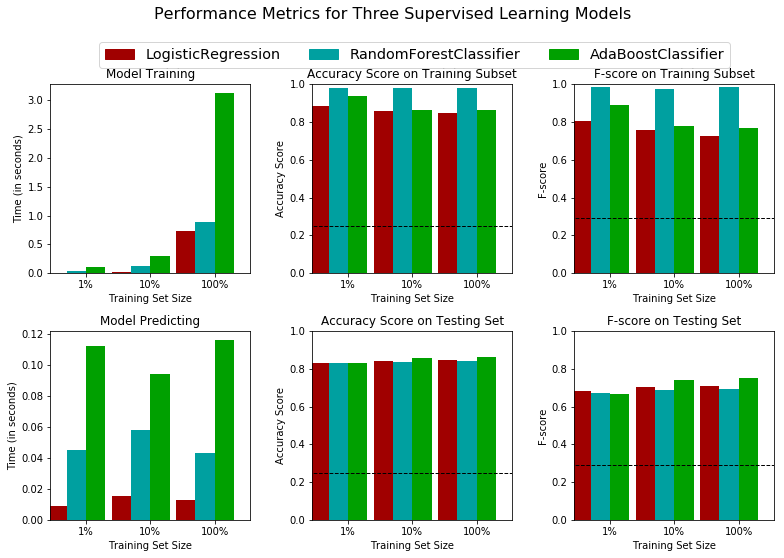

In [12]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# TODO: Initialize the three models
clf_A = LogisticRegression()
clf_B = DecisionTreeClassifier(random_state=42)
clf_C = AdaBoostClassifier(random_state=42)
clf_B = RandomForestClassifier(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = int(len(y_train))
samples_10 = int(round(len(y_train)*0.1))
samples_1 = int(round(len(y_train)*0.01))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [13]:
results = train_predict(clf_C, samples, X_train, y_train, X_test, y_test)

for key, value in results.items():
    print(key, round(value, 4))

AdaBoostClassifier trained on 36177 samples.
train_time 2.4564
pred_time 0.106
acc_train 0.8667
acc_test 0.8607
f_train 0.7703
f_test 0.7491


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

This section summarizes the main findings of the comparison between logistic regression classifier, decision tree clasifier and Adaboost classifier. The focus of the analysis lies on the $F_{0.5}$-Score in the case when 100% of the training data is used: 

**Logistic Regression Classifier:**
- Logistic regression performs comparably well to the untuned classifiers on the training as well as the test data, even though it may appear rather simplistic compared to the other two classifiers.
- Metrics: The $F_{0.5}$-Score of `0.6832` on the testing data is comparable to the untuned adaboost classifier and comparable to the F-Score of the training data of `0.6985`. This indicates that this classifier does not overfit the data. It performs not as good on the training data as the adaboost algorithm but way better than the untuned version of decision trees as the latter appears to massively overfit ('memorize') the data. 
- Prediction/training time: It has a very low prediction and training time due to its simplicity.
- Suitability: The algorithm is well suited for this case as the outcome variable is binomially distributed (0/1). However, due to the skewed nature of the data we should adjust this model's threshold value as it implicitly assumes 1 for $p \geq 0.5$ which is bad practice in this case. The optimal threshold value could be obtained using the ROC-Curve. 

**Random Forest Classifier:**
- Random Forest classifier performs almost perfectly on the training data even if there are only few data being used. Moreover, the prediction and training time is modest. 
- However, the model does not perform that good on unseen data (testing set) and for small amount of data it even performs worse than logistic regression. 
- $F_{0.5}$-Score on the testing set for the full data is smaller than that of the adaboost classifier and almost identical to the Logistic regression classifier.

**AdaBoost Classifier:**
- Of the applied algorithms the adaboost implementation has the lowest F-Score on the training dataset which is the main measure to evaluate our algorithms in the framework of this problem. 
- Metrics: The $F_{0.5}$-Score of `0.7115` for the training data is between the extreme value of the decision tree and the moderate value of the logistic regression classifier. More importantly the $F_{0.5}$-Score for the test data is the highest with `0.7246` and will thus be considered as the "best" among these three models
- prediction/training time: However, the time to train and predict is significantly higher than using the other two models.
- Suitability: This implementation is well suited for our problem. Unlike the decision tree which tends to overfit the AdaBoost Classifier generalizes way better to out-of-sample data which we want in this setting. Moreover, its predictions are more accurate in terms of accuracy as well as the $F_{0.5}$-Score


### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer:**

The chosen model is the AdaBoost algorithm using decision trees as default "weak learner". 

- Adaboost is a weighting algorithm that can be applied to any classification algorithm but is commonly used with decision trees leading in general to a very good performance.  
- The adaboost algorithm is one of different boosting algorithms which have the goal to combine many "weak learners" (simple classifiers) to create a very accurate classifier. In this case the indivdual classifiers are low-level decision trees. 
- The algorithm combines those weaker predictions by sequentially adjusting the weight of the individual contributions to a weighted sum. The result is a classifier that consists of weighted decision trees. 
- The weighting is done by sequentially adjusting (or "ADApting") the weights after each individual classifier is trained and misclassifications are identified. The weight of those misclassified data points that are hard to predict is increased. More accurate classifiers are given more weight and vice versa.
- In the end, adaboost uses the individual weak learners (decision trees in this case), combines them according to the previously determined weights and constructs a strong learner, which is used for prediction. The prediction is a type of "voting" scheme to determine the most probable outcome in each "area" of the prediction space.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [14]:
### AdaBoost: Grid Search ###

# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV

# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=42)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {"n_estimators": [100, 200, 300, 400, 600]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

In [15]:
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nChange in Accuracy/F-Score due to hyperparameter tuning \n------")
acc_diff = accuracy_score(y_test, best_predictions) - accuracy_score(y_test, predictions)
f_diff = fbeta_score(y_test, best_predictions, beta = 0.5) - fbeta_score(y_test, predictions, beta = 0.5)
print("Change of Accuracy-Score: {:.4f}".format(acc_diff))
print("Change of F-Score (beta=0.5): {:.4f}".format(f_diff))

Unoptimized model
------
Accuracy score on testing data: 0.8607
F-score on testing data: 0.7491

Optimized Model
------
Final accuracy score on the testing data: 0.8698
Final F-score on the testing data: 0.7663

Change in Accuracy/F-Score due to hyperparameter tuning 
------
Change of Accuracy-Score: 0.0091
Change of F-Score (beta=0.5): 0.0172


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.8576            | 0.8660          |
| F-score        | 0.7246            | 0.7415          |


**Answer: **

After optimization of the model the accuracy as well as the $F_{0.5}$-Score has increased!

However, the increase by `0.0084` and `0.0169`, seems to be marginal in comparison to the unoptimized model. However, as mentioned before the AdaBoost algorithm is an algorithm which in general provides good results even without hyperparameter tuning which could explain these results. 

Comparing the results to the naive prediction the Adaboost algorithm provides tremendous additional value yielding an increase in the accuracy-score of `0.6182` and `0.4498` for the $F_{0.5}$-score.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

1) Age: I expect this to be the most important factor because the older a person is the higher should their earnings be in general due to being employed longer than a younger person, promotions, completed educations and those factors. Moreover, this variable seems to be highly correlated with a better education

2) Hours-per-week: People who work more should earn more and thus making the cutoff of 50k more likely.

3) Education-num: I believe people who have more years of education should earn more reaching the cutoff easier. 

4) Education: I expect education be a very important feature especially higher degrees (e.g. masters, doctorate, etc.) should often make more than 50k a year. 

5) Occupation: There are some professions which seem to be associated with higher/lower earnings, thus it should be a good predictor in this case. 

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

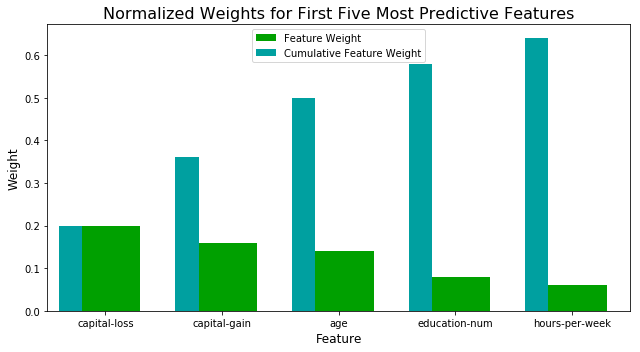

In [16]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

As I expected and discussed in Q6, "age", "hours-per-week" and "education-num" seem to be of high importance for the prediction. However, I did not consider "capital-loss" and "capital-gain" which are among the three most predictive features. 

**"Age", "hours-per-week", "education-num"**: 

The visualization confirms that these are highly predictive 

**"Capital-loss", "Capital-gain":**

I assume that these features are mostly associated with stock market gains/losses and therefore assumed that those features were mainly associated with high-earning individuals, thus, not inheriting a lot of predictive power. Apparently my assumptions were wrong as the visualization indicates. 

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [17]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8698
F-score on testing data: 0.7663

Final Model trained on reduced data
------
Accuracy on testing data: 0.8409
F-score on testing data: 0.7180


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

The reduced model performs worse than the full model. Whereas the accuracy decreased by `0.0233`, the decrease of the F-Score by `0.0367` is more substantial. Nevertheless, it should be noted that the new model has only 5 models compared to over 100 in the previous case. 

In case training time or data availability is a factor the reduced form should be considered for the analysis. In addition to the saving of time  the model is also more interpretable which may be beneficial if the model is communicated to other stakeholders for example. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

##Before You Submit
You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.

In [18]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Identifying-donors.ipynb to html',
 '[NbConvertApp] Writing 453343 bytes to Identifying-donors.html']